In [1]:
import numpy as np
import ruptures as rpt
from collections import Counter

class VotingDetector:
    def __init__(self, detectors, tolerance_window=5):
        """
        Initialize the VotingDetector.

        Parameters:
        - detectors: A list of dictionaries, where each dictionary represents a detector with its associated parameters.
        - tolerance_window: The window size to tolerate small differences between the predicted breakpoints from different detectors.
        """
        self.detectors = detectors
        self.tolerance_window = tolerance_window

    def _is_within_tolerance(self, bkp, other_bkps):
        """
        Check if a breakpoint is within tolerance of any other breakpoints.

        Parameters:
        - bkp: The breakpoint to check.
        - other_bkps: List of breakpoints to compare against.

        Returns:
        - True if bkp is within tolerance of any in other_bkps, False otherwise.
        """
        return any(abs(bkp - other_bkp) <= self.tolerance_window for other_bkp in other_bkps)

    def _majority_vote(self, all_bkps):
        """
        Perform majority voting on breakpoints across all detectors.

        Parameters:
        - all_bkps: A list of lists, where each inner list contains the breakpoints predicted by a detector.

        Returns:
        - A list of breakpoints that are consistently detected by the majority of detectors within the tolerance window.
        """
        if len(all_bkps) == 1:
            return all_bkps[0]  # If there's only one detector, return its breakpoints directly
        
        # Use a counter to keep track of how many detectors include each breakpoint
        bkp_counter = Counter()
        
        # Iterate through the breakpoints of each detector
        for bkps in all_bkps:
            for bkp in bkps:
                # Check how many times this bkp is within tolerance of other breakpoints
                for other_bkps in all_bkps:
                    if bkps != other_bkps:  
                        if self._is_within_tolerance(bkp, other_bkps):
                            bkp_counter[bkp] += 1
        
        # Determine the majority threshold
        majority_threshold = len(self.detectors) // 2
        
        # Collect breakpoints that meet the majority threshold
        voted_bkps = [bkp for bkp, count in bkp_counter.items() if count > majority_threshold]
        
        voted_bkps = sorted(voted_bkps)
        # if too close to each other, by tolerance, keep only one
        for i in range(len(voted_bkps)):
            for j in range(i+1, len(voted_bkps)):
                if abs(voted_bkps[i] - voted_bkps[j]) <= self.tolerance_window:
                    # pop
                    voted_bkps.pop(i)
        
        return sorted(voted_bkps)

    def detect(self, signal):
        """
        Detect breakpoints using multiple detectors and majority voting.

        Parameters:
        - signal: The input signal to detect breakpoints on.

        Returns:
        - A list of breakpoints that are agreed upon by the majority of detectors.
        """
        all_bkps = []
        
        # Apply each detector and collect breakpoints
        for det in self.detectors:
            algo = det['detector'].fit(signal)
            bkps = algo.predict(pen=det['pen'])[:-1]  # Exclude the last point as per usual
            all_bkps.append(bkps)
            print('Detector {} detected {} breakpoints'.format(det['title'], len(bkps)))

        # Perform majority voting on the breakpoints
        voted_bkps = self._majority_vote(all_bkps)
        
        return voted_bkps

In [2]:
import random
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import numpy as np
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils import get_column_letter
from PIL import Image as PILImage
import io

LOG_TO_XLS = False
metric_to_plot = [
                'iops', 
                'size_avg', 
                # 'offset_avg', 
                # 'iat_avg', 
                # 'read_ratio', 
                # 'write_ratio', 
                # 'read_count', 
                # 'write_count'
                ]

columns_to_merge = [
    'num_io',
    'read_count',
    # 'read_percentage',
    # 'write_count',
    # 'write_percentage',
    # 'avg_offset',
    # 'avg_size',	
    # 'ts_max',
    # 'ts_min',	
    # 'duration'		
]

metric_detector_pair = {
    'iops': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 20, 'title': 'RBF'},
    ],
    'iat_avg': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 17, 'title': 'RBF'},
        {'detector': rpt.KernelCPD(kernel='linear', min_size=25), 'pen': 1, 'title': 'LINEAR'},
        {'detector': rpt.KernelCPD(kernel="cosine", min_size=25), 'pen': 0.01, 'title': 'cosine'}
    ],
    'size_avg': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 10, 'title': 'RBF'},
    ],
    'offset_avg': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 17, 'title': 'RBF'},
        {'detector': rpt.KernelCPD(kernel='linear', min_size=25), 'pen': 1, 'title': 'LINEAR'},
        {'detector': rpt.KernelCPD(kernel="cosine", min_size=25), 'pen': 0.01, 'title': 'cosine'}
    ],
    'read_ratio': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 20, 'title': 'RBF'},
    ],
    'write_ratio': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 20, 'title': 'RBF'},
    ],
    'read_count': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 15, 'title': 'RBF'},
    ], 
    'write_count': [
        {'detector': rpt.KernelCPD(kernel='rbf', min_size=25), 'pen': 15, 'title': 'RBF'},
    ]
}

METRIC:  iops
5: PROCESSING PATH /home/cc/clio/runs/raw/alibaba_loop/characteristic/178/10m/characteristic.csv
Detector RBF detected 45 breakpoints
Delta for  34  is  0.4828833788797019
Recurring drifts: 0 - 35
Delta for  42  is  1.2461238764625207
Recurring drifts: 36 - 43
[(0, 3604), (3605, 4328)]


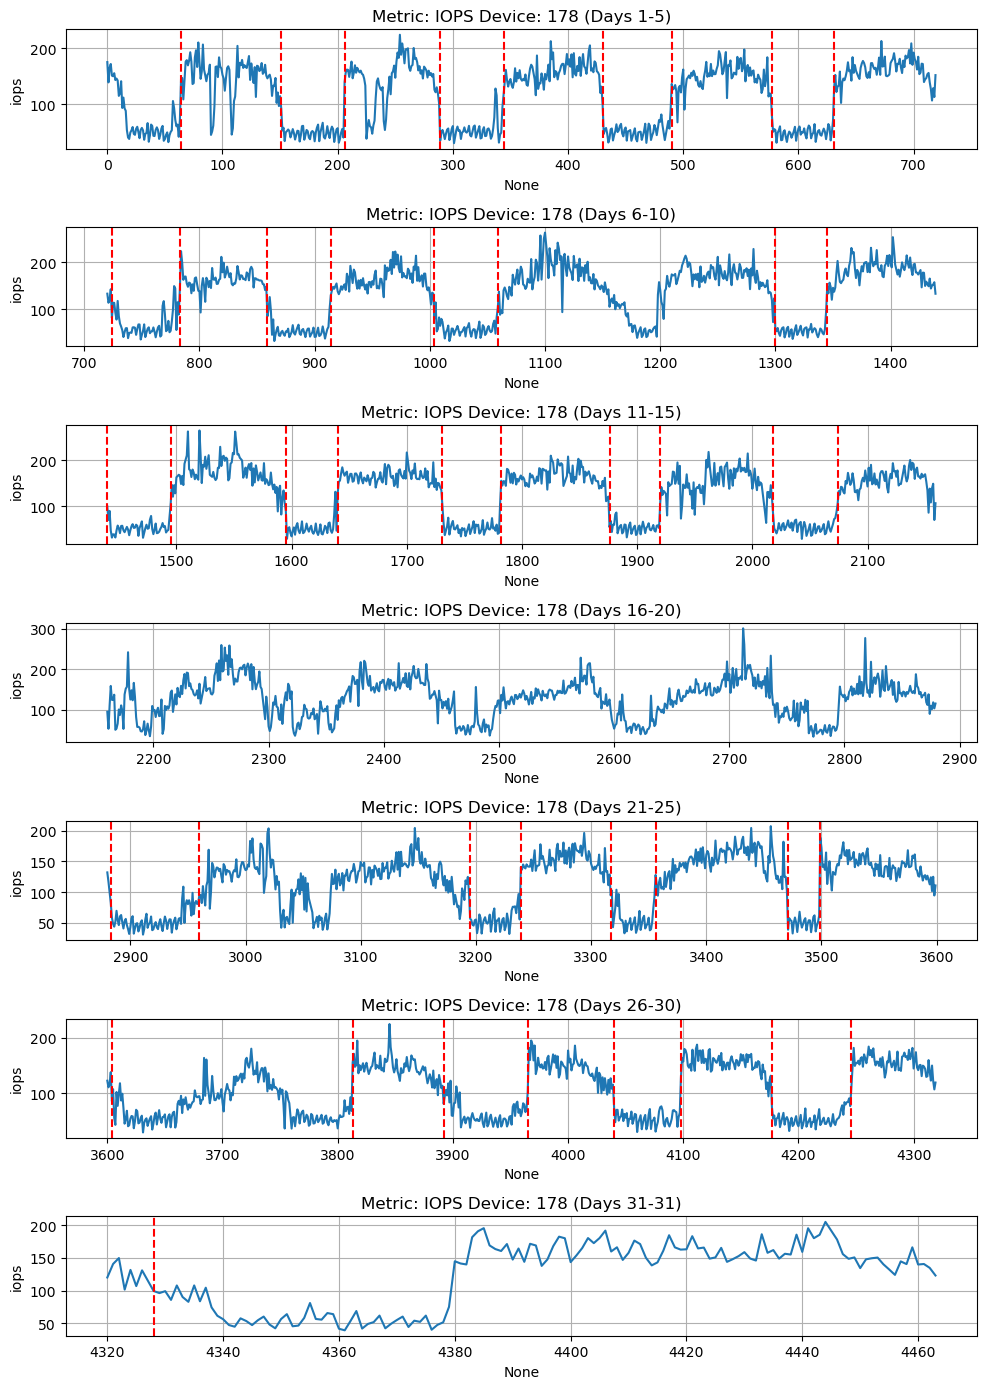

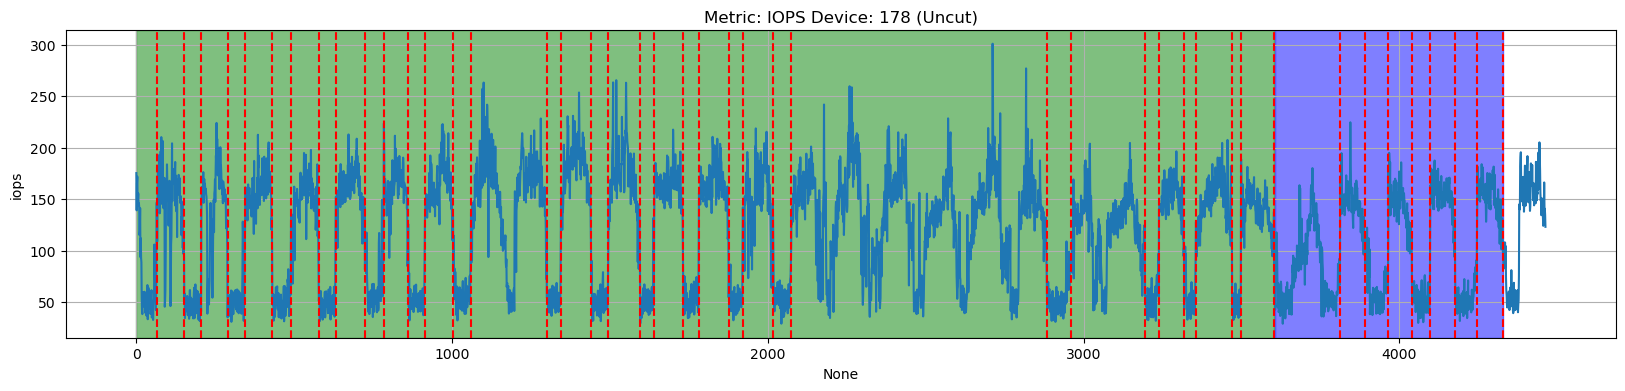

4: PROCESSING PATH /home/cc/clio/runs/raw/alibaba_loop/characteristic/33/10m/characteristic.csv
Detector RBF detected 0 breakpoints
[]


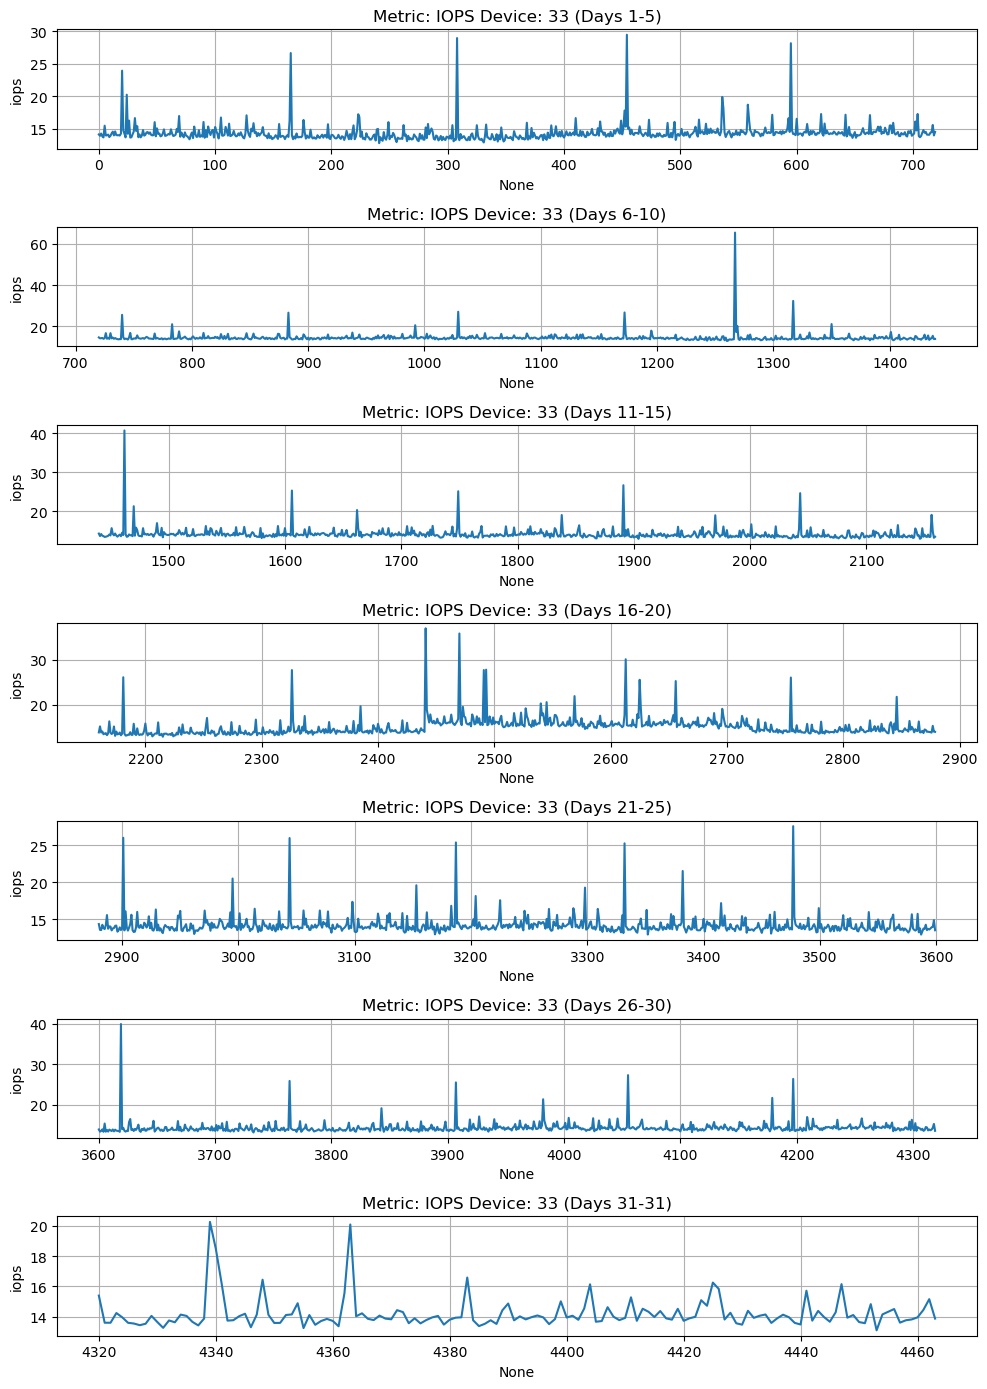

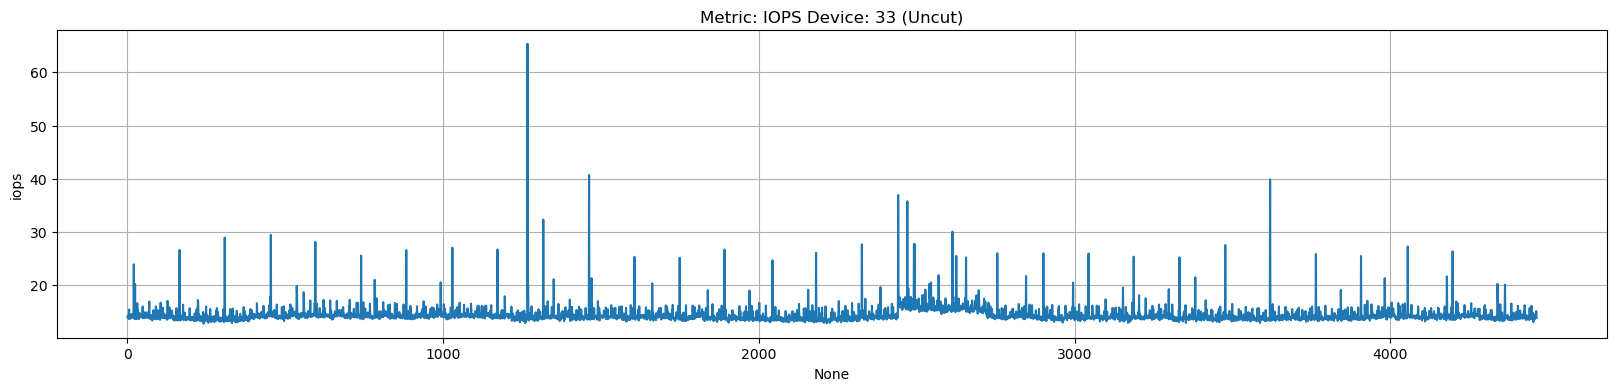

3: PROCESSING PATH /home/cc/clio/runs/raw/alibaba_loop/characteristic/234/10m/characteristic.csv


/tmp/ipykernel_3741696/3592498089.py:230: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Detector RBF detected 0 breakpoints
[]


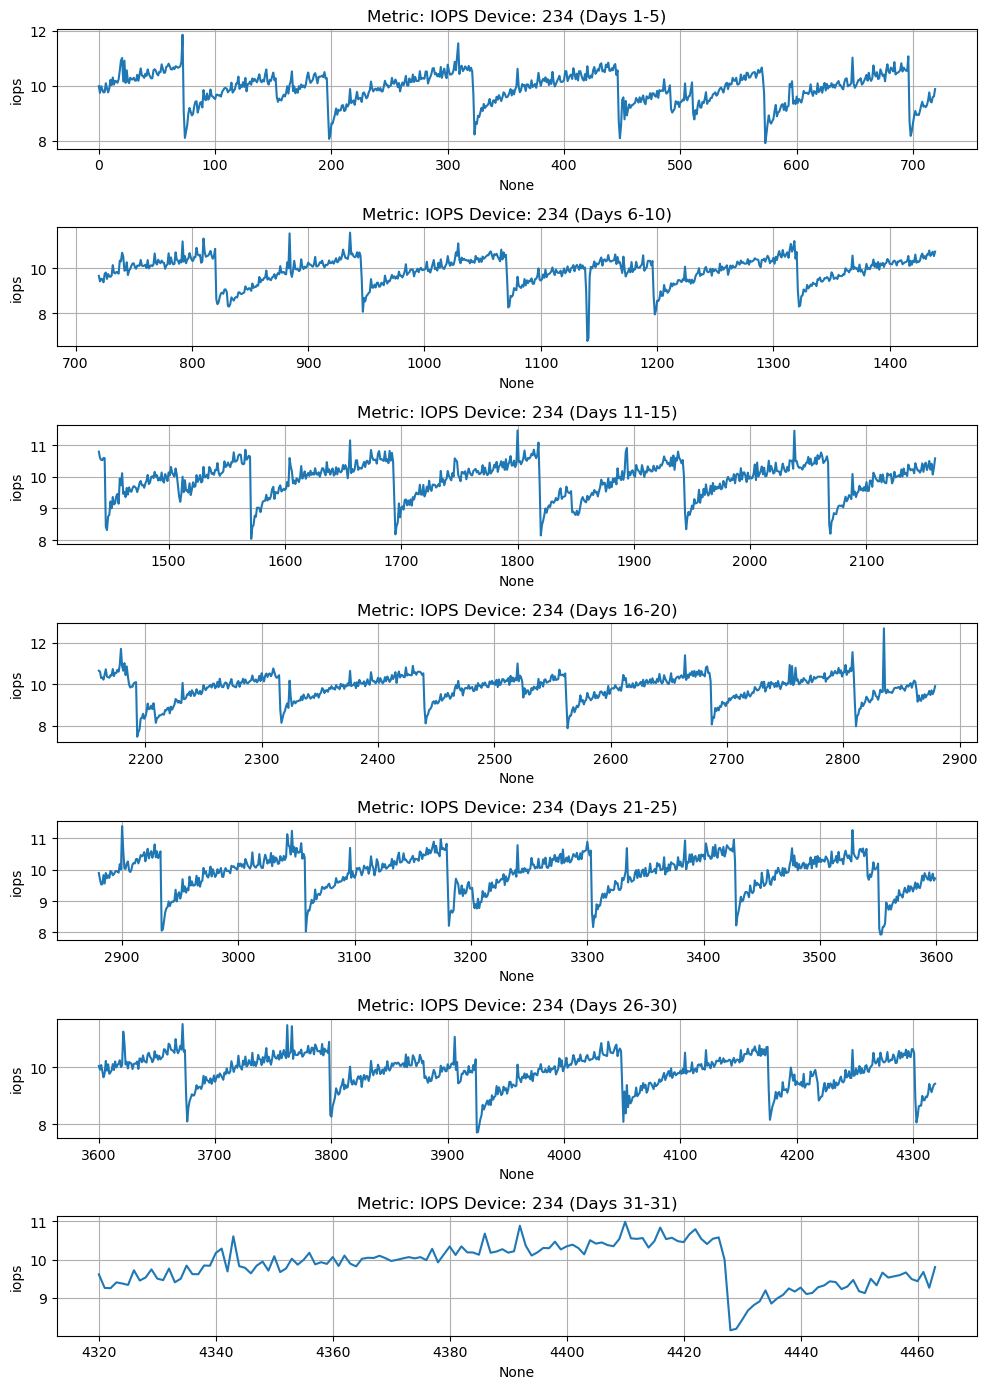

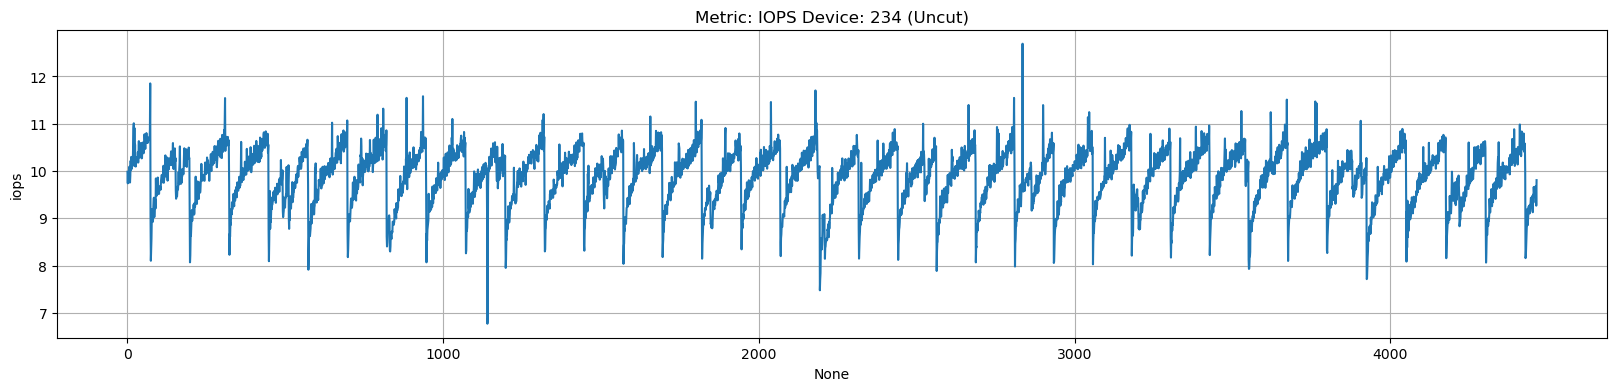

2: PROCESSING PATH /home/cc/clio/runs/raw/alibaba_loop/characteristic/76/10m/characteristic.csv
Detector RBF detected 0 breakpoints
[]


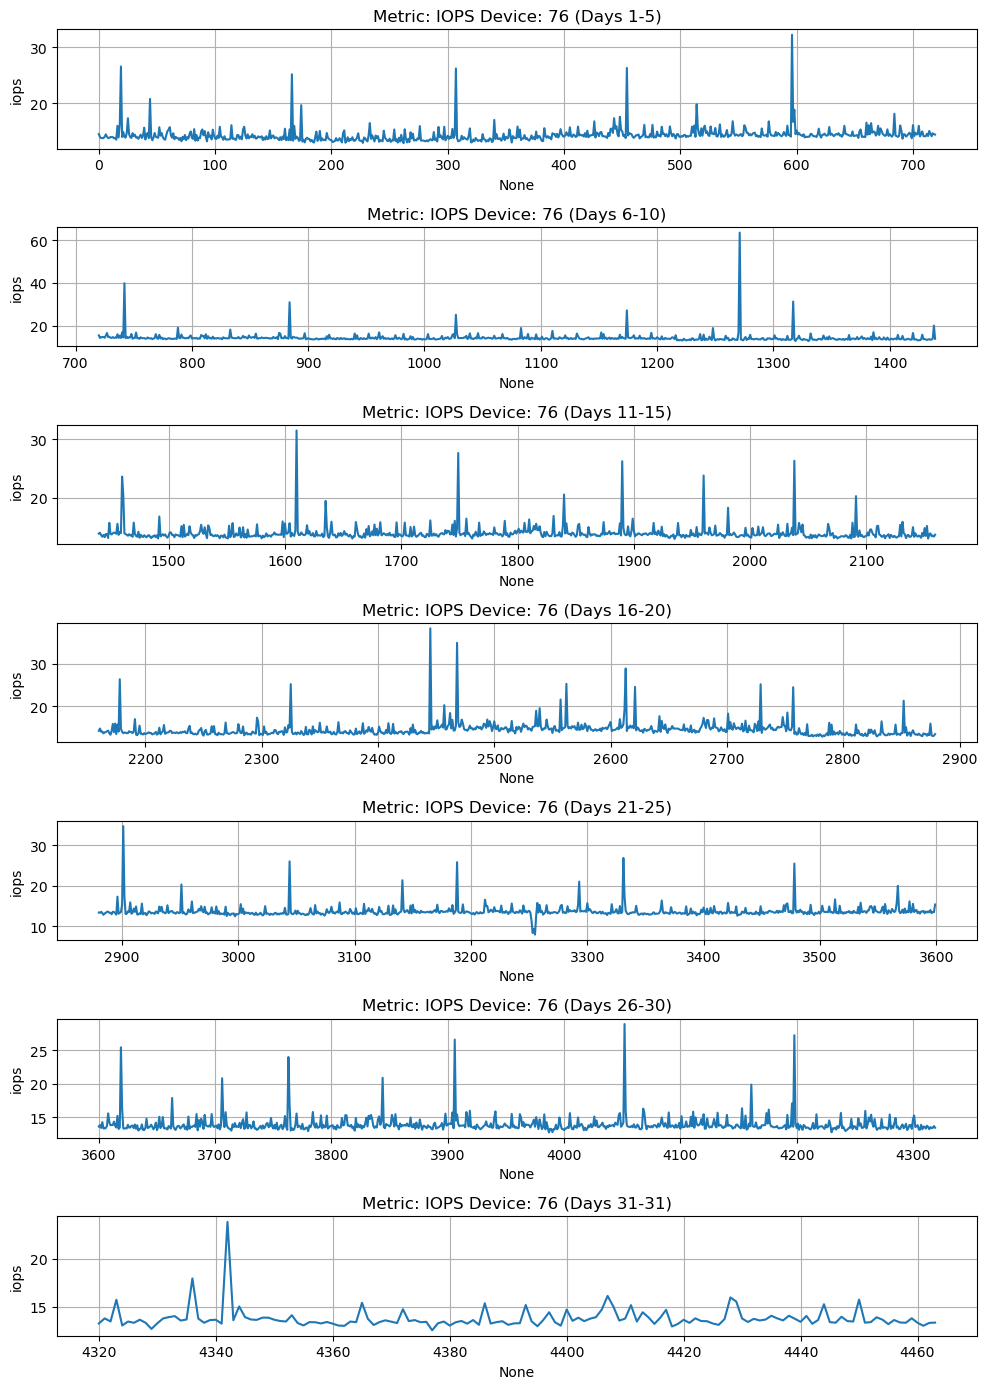

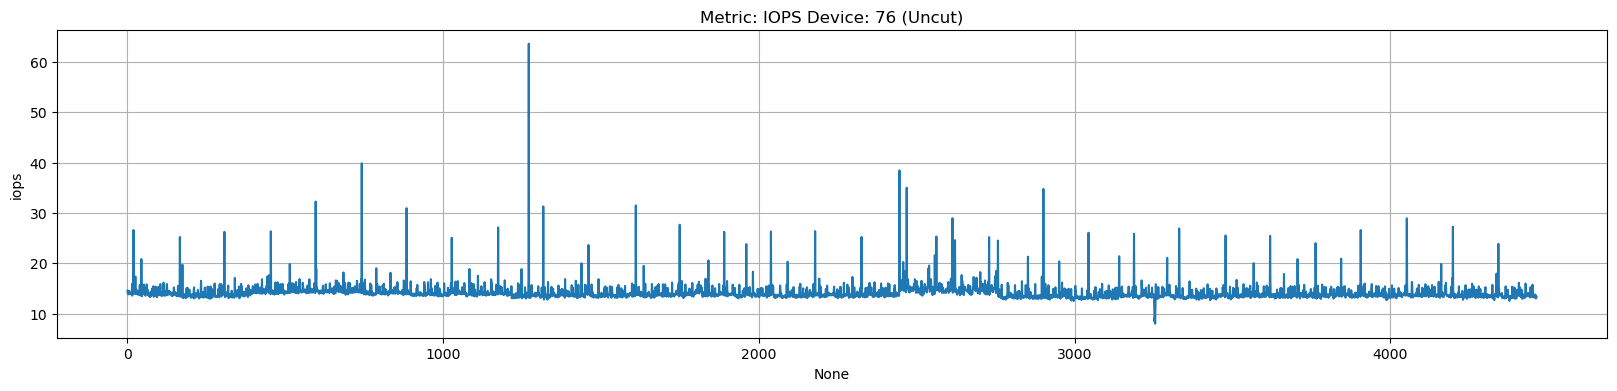

1: PROCESSING PATH /home/cc/clio/runs/raw/alibaba_loop/characteristic/810/10m/characteristic.csv


In [6]:
# Function to detect drift points using ruptures
def detect_drift(df, metric):    
    signal = df[metric].values.reshape(-1, 1)
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    
    detector = VotingDetector(detectors=metric_detector_pair[metric], tolerance_window=25)
    my_bkps = detector.detect(signal)
    
    return my_bkps[:-1]  # Exclude the last point

# Function to calculate drift indices and drift ranges
def calculate_drift_indices_and_ranges(drift_positions, df_col):
    df_length = len(df_col)
    
    if len(drift_positions) == 0:
        return [(0, df_length-1)], [(round(df_col.iloc[0],2), round(df_col.iloc[-1],2))]
    
    drift_indices = [(0, drift_positions[0])] + [(drift_positions[i] + 1, drift_positions[i+1]) for i in range(len(drift_positions)-1)] + [(drift_positions[-1], df_length-1)]
    drift_ranges = [(round(df_col.iloc[i],2), round(df_col.iloc[j],2)) for (i, j) in drift_indices]
    return drift_indices, drift_ranges

# Plot function for per-day image
def plot_per_day(df, metric, device_id, drift_positions, minute_from_time, recurring_indices):
    days_per_subplot = 5
    total_minutes = len(df) * int(minute_from_time)
    total_days = total_minutes / 1440
    num_subplots = int(total_days / days_per_subplot) + (1 if total_days % days_per_subplot != 0 else 0)
    
    fig, axs = plt.subplots(num_subplots, 1, figsize=(10, 2 * num_subplots))
    if num_subplots == 1:
        axs = [axs] 
    
    for i in range(num_subplots):
        start_index = i * days_per_subplot * 1440 // int(minute_from_time)
        end_index = start_index + days_per_subplot * 1440 // int(minute_from_time)
        ax = axs[i]
        sns.lineplot(data=df.iloc[start_index:end_index], x=df.index[start_index:end_index], y=metric, ax=ax)
        
        # Add drift points and vertical ticks every day
        for tick in drift_positions:
            if start_index <= tick < end_index:
                ax.axvline(x=tick, color='r', linestyle='--', label='Drift Point')
                
        ax.set_title(f"Metric: {metric.upper()} Device: {device_id} (Days {i*days_per_subplot+1}-{min((i+1)*days_per_subplot, int(total_days))})")
        ax.grid()
            

    plt.tight_layout()
    return save_plot_to_buffer(fig)

# Plot function for the uncut full picture
def plot_uncut(df, metric, device_id, drift_positions, recurring_indices):
    plt.figure(figsize=(20, 4))
    sns.lineplot(data=df, x=df.index, y=metric)
    
    for tick in drift_positions:
        plt.axvline(x=tick, color='r', linestyle='--', label='Drift Point')
        
    # alternate the colors
    for idx, (start, end) in enumerate(recurring_indices):
        # color the indices differently, from start to end x axis
        plt.axvspan(start, end, color='g' if idx % 2 == 0 else 'b', alpha=0.5)
    
    plt.title(f"Metric: {metric.upper()} Device: {device_id} (Uncut)")
    plt.grid()
    plt.show()
    return save_plot_to_buffer(plt)

# Function to save the plot into a buffer
def save_plot_to_buffer(fig):
    if not LOG_TO_XLS:
        return None
    buffer = io.BytesIO()
    fig.savefig(buffer, format='png', bbox_inches='tight')
    plt.close()
    
    buffer.seek(0)
    img = PILImage.open(buffer)
    
    compressed_buffer = io.BytesIO()
    rgb_im = img.convert('RGB')
    rgb_im.save(compressed_buffer, format='JPEG', optimize=True, quality=50)
    
    return compressed_buffer

# Save plot to Excel function
def save_plot_to_excel(ws, row, plot_buffer_per_day, plot_buffer_uncut, device_id, drift_indices, drift_ranges):
    if not LOG_TO_XLS:
        return
    ws[f"A{row}"] = device_id
    
    # Adding drift indices and ranges to the new columns
    ws[f"D{row}"] = str(drift_indices)
    ws[f"E{row}"] = str(drift_ranges)
    
    img_per_day = Image(plot_buffer_per_day)
    img_per_day.width = img_per_day.width // 2
    img_per_day.height = img_per_day.height // 2
    ws.add_image(img_per_day, f"B{row}")
    
    img_uncut = Image(plot_buffer_uncut)
    img_uncut.width = img_uncut.width // 2
    img_uncut.height = img_uncut.height // 2
    ws.add_image(img_uncut, f"C{row}")
    
    ws.row_dimensions[row].height = max(img_per_day.height, img_uncut.height) / 1.2 # Adjust height for each row
    ws.column_dimensions['B'].width = img_per_day.width/6
    ws.column_dimensions['C'].width = img_uncut.width/7
    ws.column_dimensions['D'].width = 30
    ws.column_dimensions['E'].width = 30


def save_additional_info_to_excel(ws, row, drift_indices, df, metric, tol=0.4):
    col = 6  
    
    avg_drift_col = col
    var_drift_col = col + 1
    avg_duration_col = col + 2
    max_col = col + 3
    min_col = col + 4

    weighted_averages = []
    weighted_variances = []
    durations = []
    max_vals = []
    min_vals = []
    unweighted_averages = []

    for idx, drift_range in enumerate(drift_indices):
        start, end = drift_range

        drift_data = df[(df.index >= start) & (df.index <= end)]
        
        weights = drift_data['num_io']
        values = drift_data[metric]
        
        weighted_avg = np.average(values, weights=weights)
        weighted_var = np.average((values - weighted_avg) ** 2, weights=weights)
        unweighted_avg = np.average(values)
        unweighted_averages.append(unweighted_avg)
        
        duration = end - start

        max_val = values.max()
        min_val = values.min()

        weighted_averages.append(weighted_avg)
        weighted_variances.append(np.sqrt(weighted_var))  
        durations.append(duration)
        max_vals.append(max_val)
        min_vals.append(min_val)

    idx = 0
    start_recurr = -1
    end_recurr = -1
    recurring_drifts = []
    
    while idx < len(unweighted_averages) - 2:
        if start_recurr == -1:
            start_recurr = idx
        
        delta = abs(unweighted_averages[idx] - unweighted_averages[idx+2])/(unweighted_averages[idx])
        if delta < (tol): 
            end_recurr = idx + 2
            if idx == len(unweighted_averages) - 3:
                print(f"Recurring drifts: {start_recurr} - {end_recurr}")
                recurring_drifts.append((start_recurr, end_recurr))
        else:
            print("Delta for ", idx, " is ", delta)
            if end_recurr != -1:
                print(f"Recurring drifts: {start_recurr} - {end_recurr}")    
                recurring_drifts.append((start_recurr, end_recurr))
            start_recurr = max(idx, end_recurr) + 1
            end_recurr = -1
            idx = max(idx, start_recurr)
        idx += 1
    
    if not LOG_TO_XLS:
        return recurring_drifts
    # Write the header name
    ws.cell(row=1, column=avg_drift_col, value="Weighted Average")
    ws.cell(row=1, column=var_drift_col, value="Weighted Variance")
    ws.cell(row=1, column=avg_duration_col, value="Average Duration (10 mins)")
    ws.cell(row=1, column=max_col, value="Max Value")
    ws.cell(row=1, column=min_col, value="Min Value")
    
    ws.cell(row=row, column=avg_drift_col, value=f'[{ ",".join([str(round(avg, 2)) for avg in weighted_averages]) }]')
    ws.cell(row=row, column=var_drift_col, value=f'[{ ",".join([str(round(var, 2)) for var in weighted_variances]) }]')
    
    avg_duration = np.mean(durations)
    ws.cell(row=row, column=avg_duration_col, value=round(avg_duration,2))
    
    overall_max = np.max(max_vals)
    overall_min = np.min(min_vals)
    ws.cell(row=row, column=max_col, value=round(overall_max,2))
    ws.cell(row=row, column=min_col, value=round(overall_min,2))
    
    return recurring_drifts
    

path_to_char = '/home/cc/clio/runs/raw/alibaba_loop/characteristic'
path_to_merge = '/home/cc/clio/nix-utils/alibaba_device_rw-device_counts.csv'
workbook = Workbook()
default_sheet = workbook.active
workbook.remove(default_sheet)

df_to_merge = pd.read_csv(path_to_merge)
for metric in metric_to_plot:
    print("METRIC: ", metric)
    device_limit = 5
    ws = workbook.create_sheet(title=metric)
    # for col in range(1, 21):
    #     ws.column_dimensions[get_column_letter(col)].width = 20 
    
    # ws["A1"] = "Device ID"
    # ws["B1"] = "Per Day Picture"
    # ws["C1"] = "Uncut Picture"
    # ws["D1"] = "Drift Indices"
    # ws["E1"] = "Drift Ranges"
    
    # # Write df to merge columns
    # for i, column in enumerate(columns_to_merge):
    #     ws.cell(row=1, column=11+i, value=f'device_{column}')
    
    row = 2
    
    for path_10m in Path(path_to_char).rglob("10m"):
        for path in Path(path_10m).rglob("*.csv"):
            print(f"{device_limit}: PROCESSING PATH", path)
            df = pd.read_csv(path)
            minute_from_time = re.search(r"(\d+)m", str(path)).group(1)
            device_id = re.search(r"characteristic/(\d+)", str(path)).group(1)
            
            
            drift_positions = detect_drift(df, metric)
            
            # Generate the drift indices and ranges
            drift_indices, drift_ranges = calculate_drift_indices_and_ranges(drift_positions, df[metric])
            
            # Generate the per-day and uncut plots
            recurring_drifts = save_additional_info_to_excel(ws, row, drift_indices, df, metric)
            # drift_ranges contains tuples of (start, end) for each drift
            # recurring_drfits contains indices of the tuple that needs to be appended
            recurring_indices = []
            for chunks_to_append in recurring_drifts:
                first_chunk, last_chunk = chunks_to_append
                first_range = drift_indices[first_chunk]
                last_range = drift_indices[last_chunk]
                recurring_indices += [(first_range[0], last_range[1])]
            print(recurring_indices)
            plot_buffer_per_day = plot_per_day(df, metric, device_id, drift_positions, minute_from_time, recurring_indices)
            plot_buffer_uncut = plot_uncut(df, metric, device_id, drift_positions, recurring_indices)
            
            # # Save plots and device info to Excel
            # save_plot_to_excel(ws, row, plot_buffer_per_day, plot_buffer_uncut, device_id, drift_indices, drift_ranges)
            
            # device_row_merge = df_to_merge[df_to_merge['device_id'] == int(device_id)]
            # for i, column in enumerate(columns_to_merge):
            #     ws.cell(row=row, column=11+i, value=device_row_merge[column].values[0])
            
            row += 1  # Increment row for each entry
            device_limit -= 1
        if device_limit == 0:
            break
# workbook.save("metric_plots_with_drift.xlsx")

In [11]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import pandas as pd
from pathlib import Path

def cluster_time_series(df, n_clusters):
    # Assuming your DataFrame is structured with timestamps as index and the metric as the column
    data = df.values  # Convert DataFrame to numpy array
    data = data.reshape((data.shape[0], data.shape[1], 1))  # Reshape for tslearn

    # Scale the data
    scaler = TimeSeriesScalerMinMax()
    data_scaled = scaler.fit_transform(data)

    # Perform KMeans clustering
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_init=10)
    labels = model.fit_predict(data_scaled)

    return labels, model


path_to_char = '/home/cc/clio/runs/raw/alibaba_loop/characteristic'
path_to_merge = '/home/cc/clio/nix-utils/alibaba_device_rw-device_counts.csv'
df_to_merge = pd.read_csv(path_to_merge)

metric_to_plot = df_to_merge.columns[1:]  # Adjust this if needed

for metric in metric_to_plot:
    print("METRIC: ", metric)
    
    device_data = []  # Store data for clustering
    device_ids = []   # Store corresponding device IDs

    for path_10m in Path(path_to_char).rglob("10m"):
        for path in Path(path_10m).rglob("*.csv"):
            device_id = re.search(r"characteristic/(\d+)", str(path)).group(1)
            print(f"PROCESSING DEVICE {device_id} from {path}")
            
            df_1_device = pd.read_csv(path)
            if metric in df_1_device.columns:
                device_ids.append(device_id)
                device_data.append(df_1_device[metric].values)  # Assuming the metric is in column format

    # Create a DataFrame for the clustering
    device_df = pd.DataFrame(device_data).T
    device_df.columns = device_ids

    # Cluster the time series data
    n_clusters = 3  # Adjust this based on your needs
    labels, model = cluster_time_series(device_df, n_clusters)

    print(labels)


METRIC:  num_io
PROCESSING DEVICE 178 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/178/10m/characteristic.csv


PROCESSING DEVICE 33 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/33/10m/characteristic.csv
PROCESSING DEVICE 234 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/234/10m/characteristic.csv
PROCESSING DEVICE 76 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/76/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 810 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/810/10m/characteristic.csv
PROCESSING DEVICE 228 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/228/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 128 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/128/10m/characteristic.csv
PROCESSING DEVICE 46 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/46/10m/characteristic.csv
PROCESSING DEVICE 52 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/52/10m/characteristic.csv
PROCESSING DEVICE 7 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/7/10m/characteristic.csv
PROCESSING DEVICE 173 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/173/10m/characteristic.csv
PROCESSING DEVICE 276 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/276/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 262 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/262/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 56 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/56/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 207 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/207/10m/characteristic.csv
PROCESSING DEVICE 48 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/48/10m/characteristic.csv
PROCESSING DEVICE 77 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/77/10m/characteristic.csv
PROCESSING DEVICE 49 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/49/10m/characteristic.csv
PROCESSING DEVICE 283 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/283/10m/characteristic.csv
PROCESSING DEVICE 746 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/746/10m/characteristic.csv
PROCESSING DEVICE 332 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/332/10m/characteristic.csv
PROCESSING DEVICE 236 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/236/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 804 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/804/10m/characteristic.csv
PROCESSING DEVICE 91 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/91/10m/characteristic.csv
PROCESSING DEVICE 195 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/195/10m/characteristic.csv
PROCESSING DEVICE 241 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/241/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 9 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/9/10m/characteristic.csv
PROCESSING DEVICE 263 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/263/10m/characteristic.csv
PROCESSING DEVICE 72 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/72/10m/characteristic.csv
PROCESSING DEVICE 293 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/293/10m/characteristic.csv
PROCESSING DEVICE 289 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/289/10m/characteristic.csv
PROCESSING DEVICE 8 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/8/10m/characteristic.csv
PROCESSING DEVICE 219 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/219/10m/characteristic.csv
PROCESSING DEVICE 113 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/113/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 141 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/141/10m/characteristic.csv
PROCESSING DEVICE 181 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/181/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 727 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/727/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 32 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/32/10m/characteristic.csv
PROCESSING DEVICE 144 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/144/10m/characteristic.csv
PROCESSING DEVICE 2 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/2/10m/characteristic.csv
PROCESSING DEVICE 40 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/40/10m/characteristic.csv
PROCESSING DEVICE 78 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/78/10m/characteristic.csv
PROCESSING DEVICE 225 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/225/10m/characteristic.csv
PROCESSING DEVICE 107 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/107/10m/characteristic.csv
PROCESSING DEVICE 86 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/86/10m/characteristic.csv
PROCESSING DEVICE 21 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/21/10m/characteristic.csv
PROCESSING DEVICE 30 from /home/cc/clio/runs/raw/alibaba_loop/charact

/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 137 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/137/10m/characteristic.csv
PROCESSING DEVICE 3 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/3/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 87 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/87/10m/characteristic.csv
PROCESSING DEVICE 115 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/115/10m/characteristic.csv
PROCESSING DEVICE 192 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/192/10m/characteristic.csv
PROCESSING DEVICE 679 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/679/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 507 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/507/10m/characteristic.csv
PROCESSING DEVICE 631 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/631/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 295 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/295/10m/characteristic.csv
PROCESSING DEVICE 466 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/466/10m/characteristic.csv
PROCESSING DEVICE 83 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/83/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 256 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/256/10m/characteristic.csv
PROCESSING DEVICE 92 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/92/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 79 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/79/10m/characteristic.csv
PROCESSING DEVICE 66 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/66/10m/characteristic.csv
PROCESSING DEVICE 148 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/148/10m/characteristic.csv
PROCESSING DEVICE 335 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/335/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 147 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/147/10m/characteristic.csv
PROCESSING DEVICE 190 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/190/10m/characteristic.csv
PROCESSING DEVICE 24 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/24/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 740 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/740/10m/characteristic.csv
PROCESSING DEVICE 23 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/23/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 239 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/239/10m/characteristic.csv
PROCESSING DEVICE 68 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/68/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 174 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/174/10m/characteristic.csv
PROCESSING DEVICE 5 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/5/10m/characteristic.csv
PROCESSING DEVICE 62 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/62/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 522 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/522/10m/characteristic.csv
PROCESSING DEVICE 247 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/247/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 154 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/154/10m/characteristic.csv
PROCESSING DEVICE 54 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/54/10m/characteristic.csv
PROCESSING DEVICE 117 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/117/10m/characteristic.csv
PROCESSING DEVICE 88 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/88/10m/characteristic.csv
PROCESSING DEVICE 277 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/277/10m/characteristic.csv
PROCESSING DEVICE 354 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/354/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 193 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/193/10m/characteristic.csv
PROCESSING DEVICE 188 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/188/10m/characteristic.csv
PROCESSING DEVICE 206 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/206/10m/characteristic.csv
PROCESSING DEVICE 177 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/177/10m/characteristic.csv
PROCESSING DEVICE 121 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/121/10m/characteristic.csv
PROCESSING DEVICE 311 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/311/10m/characteristic.csv
PROCESSING DEVICE 391 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/391/10m/characteristic.csv
PROCESSING DEVICE 124 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/124/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 12 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/12/10m/characteristic.csv
PROCESSING DEVICE 131 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/131/10m/characteristic.csv
PROCESSING DEVICE 435 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/435/10m/characteristic.csv
PROCESSING DEVICE 19 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/19/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 651 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/651/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (322,382) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


[1 1 1 ... 0 0 0]
METRIC:  read_count
PROCESSING DEVICE 178 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/178/10m/characteristic.csv
PROCESSING DEVICE 33 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/33/10m/characteristic.csv
PROCESSING DEVICE 234 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/234/10m/characteristic.csv
PROCESSING DEVICE 76 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/76/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 810 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/810/10m/characteristic.csv
PROCESSING DEVICE 228 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/228/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 128 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/128/10m/characteristic.csv
PROCESSING DEVICE 46 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/46/10m/characteristic.csv
PROCESSING DEVICE 52 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/52/10m/characteristic.csv
PROCESSING DEVICE 7 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/7/10m/characteristic.csv
PROCESSING DEVICE 173 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/173/10m/characteristic.csv
PROCESSING DEVICE 276 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/276/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 262 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/262/10m/characteristic.csv
PROCESSING DEVICE 56 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/56/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 207 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/207/10m/characteristic.csv
PROCESSING DEVICE 48 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/48/10m/characteristic.csv
PROCESSING DEVICE 77 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/77/10m/characteristic.csv
PROCESSING DEVICE 49 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/49/10m/characteristic.csv
PROCESSING DEVICE 283 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/283/10m/characteristic.csv
PROCESSING DEVICE 746 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/746/10m/characteristic.csv
PROCESSING DEVICE 332 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/332/10m/characteristic.csv
PROCESSING DEVICE 236 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/236/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 804 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/804/10m/characteristic.csv
PROCESSING DEVICE 91 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/91/10m/characteristic.csv
PROCESSING DEVICE 195 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/195/10m/characteristic.csv
PROCESSING DEVICE 241 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/241/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 9 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/9/10m/characteristic.csv
PROCESSING DEVICE 263 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/263/10m/characteristic.csv
PROCESSING DEVICE 72 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/72/10m/characteristic.csv
PROCESSING DEVICE 293 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/293/10m/characteristic.csv
PROCESSING DEVICE 289 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/289/10m/characteristic.csv
PROCESSING DEVICE 8 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/8/10m/characteristic.csv
PROCESSING DEVICE 219 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/219/10m/characteristic.csv
PROCESSING DEVICE 113 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/113/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 141 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/141/10m/characteristic.csv
PROCESSING DEVICE 181 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/181/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 727 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/727/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 32 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/32/10m/characteristic.csv
PROCESSING DEVICE 144 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/144/10m/characteristic.csv
PROCESSING DEVICE 2 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/2/10m/characteristic.csv
PROCESSING DEVICE 40 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/40/10m/characteristic.csv
PROCESSING DEVICE 78 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/78/10m/characteristic.csv
PROCESSING DEVICE 225 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/225/10m/characteristic.csv
PROCESSING DEVICE 107 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/107/10m/characteristic.csv
PROCESSING DEVICE 86 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/86/10m/characteristic.csv
PROCESSING DEVICE 21 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/21/10m/characteristic.csv
PROCESSING DEVICE 30 from /home/cc/clio/runs/raw/alibaba_loop/charact

/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 137 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/137/10m/characteristic.csv
PROCESSING DEVICE 3 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/3/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 87 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/87/10m/characteristic.csv
PROCESSING DEVICE 115 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/115/10m/characteristic.csv
PROCESSING DEVICE 192 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/192/10m/characteristic.csv
PROCESSING DEVICE 679 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/679/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 507 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/507/10m/characteristic.csv
PROCESSING DEVICE 631 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/631/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 295 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/295/10m/characteristic.csv
PROCESSING DEVICE 466 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/466/10m/characteristic.csv
PROCESSING DEVICE 83 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/83/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 256 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/256/10m/characteristic.csv
PROCESSING DEVICE 92 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/92/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 79 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/79/10m/characteristic.csv
PROCESSING DEVICE 66 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/66/10m/characteristic.csv
PROCESSING DEVICE 148 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/148/10m/characteristic.csv
PROCESSING DEVICE 335 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/335/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 147 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/147/10m/characteristic.csv
PROCESSING DEVICE 190 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/190/10m/characteristic.csv
PROCESSING DEVICE 24 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/24/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 740 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/740/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 23 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/23/10m/characteristic.csv
PROCESSING DEVICE 239 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/239/10m/characteristic.csv
PROCESSING DEVICE 68 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/68/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 174 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/174/10m/characteristic.csv
PROCESSING DEVICE 5 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/5/10m/characteristic.csv
PROCESSING DEVICE 62 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/62/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 522 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/522/10m/characteristic.csv
PROCESSING DEVICE 247 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/247/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 154 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/154/10m/characteristic.csv
PROCESSING DEVICE 54 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/54/10m/characteristic.csv
PROCESSING DEVICE 117 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/117/10m/characteristic.csv
PROCESSING DEVICE 88 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/88/10m/characteristic.csv
PROCESSING DEVICE 277 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/277/10m/characteristic.csv
PROCESSING DEVICE 354 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/354/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 193 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/193/10m/characteristic.csv
PROCESSING DEVICE 188 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/188/10m/characteristic.csv
PROCESSING DEVICE 206 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/206/10m/characteristic.csv
PROCESSING DEVICE 177 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/177/10m/characteristic.csv
PROCESSING DEVICE 121 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/121/10m/characteristic.csv
PROCESSING DEVICE 311 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/311/10m/characteristic.csv
PROCESSING DEVICE 391 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/391/10m/characteristic.csv
PROCESSING DEVICE 124 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/124/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 12 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/12/10m/characteristic.csv
PROCESSING DEVICE 131 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/131/10m/characteristic.csv
PROCESSING DEVICE 435 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/435/10m/characteristic.csv
PROCESSING DEVICE 19 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/19/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 651 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/651/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (322,382) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


[0 0 0 ... 0 0 0]
METRIC:  write_count
PROCESSING DEVICE 178 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/178/10m/characteristic.csv
PROCESSING DEVICE 33 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/33/10m/characteristic.csv
PROCESSING DEVICE 234 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/234/10m/characteristic.csv
PROCESSING DEVICE 76 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/76/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 810 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/810/10m/characteristic.csv
PROCESSING DEVICE 228 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/228/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 128 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/128/10m/characteristic.csv
PROCESSING DEVICE 46 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/46/10m/characteristic.csv
PROCESSING DEVICE 52 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/52/10m/characteristic.csv
PROCESSING DEVICE 7 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/7/10m/characteristic.csv
PROCESSING DEVICE 173 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/173/10m/characteristic.csv
PROCESSING DEVICE 276 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/276/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 262 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/262/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 56 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/56/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 207 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/207/10m/characteristic.csv
PROCESSING DEVICE 48 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/48/10m/characteristic.csv
PROCESSING DEVICE 77 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/77/10m/characteristic.csv
PROCESSING DEVICE 49 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/49/10m/characteristic.csv
PROCESSING DEVICE 283 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/283/10m/characteristic.csv
PROCESSING DEVICE 746 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/746/10m/characteristic.csv
PROCESSING DEVICE 332 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/332/10m/characteristic.csv
PROCESSING DEVICE 236 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/236/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)
/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 804 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/804/10m/characteristic.csv
PROCESSING DEVICE 91 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/91/10m/characteristic.csv
PROCESSING DEVICE 195 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/195/10m/characteristic.csv
PROCESSING DEVICE 241 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/241/10m/characteristic.csv


/tmp/ipykernel_3729293/1141222730.py:39: DtypeWarning: Columns (352) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1_device = pd.read_csv(path)


PROCESSING DEVICE 9 from /home/cc/clio/runs/raw/alibaba_loop/characteristic/9/10m/characteristic.csv


KeyboardInterrupt: 